<a href="https://colab.research.google.com/github/shireesh-kumar/Pharmaceutical-Image-Categorization/blob/main/binary_classifier_swin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import torch
from torch import nn, optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import timm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Constants
LEARNING_RATE = 0.001
TRAIN_BATCH_SIZE = 32
TEST_BATCH_SIZE = 32
NUM_EPOCHS = 20

# Set device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data transformations
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load dataset
dataset_root = '/content/drive/MyDrive/cv'
image_datasets = datasets.ImageFolder(root=dataset_root, transform=data_transforms)

# Split the data into training, validation, and test sets
train_data, test_data = train_test_split(image_datasets, test_size=0.2, stratify=image_datasets.targets)
train_data, val_data = train_test_split(train_data, test_size=0.25, stratify=[target for _, target in train_data])

# Create data loaders
train_loader = DataLoader(train_data, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=TEST_BATCH_SIZE)
test_loader = DataLoader(test_data, batch_size=TEST_BATCH_SIZE)

# Initialize the model
model = nn.Sequential(
    timm.create_model('swin_base_patch4_window7_224', pretrained=True, num_classes=len(image_datasets.classes))
)
model = model.to(DEVICE)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

# Arrays to store metrics for plotting
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [ ]:
# Train the model
best_val_acc = 0.0
for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss, val_correct = 0.0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_correct += (predicted == labels).sum().item()

    val_accuracy = val_correct / len(val_loader.dataset)
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch + 1}/{NUM_EPOCHS}] Training Loss: {train_loss}, Training Accuracy: {train_accuracy}, Validation Loss: {val_loss / len(val_loader)}, Validation Accuracy: {val_accuracy}")

    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        torch.save(model.state_dict(), "best_model.pth")

    scheduler.step()


Epoch [1/20] Training Loss: 0.6599154449716399, Training Accuracy: 0.7120190400634668, Validation Loss: 0.5205048112957565, Validation Accuracy: 0.7550535077288941
Epoch [2/20] Training Loss: 0.5640689843817602, Training Accuracy: 0.7334391114637049, Validation Loss: 0.554190914939951, Validation Accuracy: 0.737217598097503
Epoch [3/20] Training Loss: 0.5681142188325713, Training Accuracy: 0.7266957556525189, Validation Loss: 0.5252073881802736, Validation Accuracy: 0.7705112960760999
Epoch [4/20] Training Loss: 0.5218532383441925, Training Accuracy: 0.7588258627528759, Validation Loss: 0.4917992419666714, Validation Accuracy: 0.7776456599286563
Epoch [5/20] Training Loss: 0.5123556727849985, Training Accuracy: 0.7679492264974217, Validation Loss: 0.49641479165465746, Validation Accuracy: 0.7740784780023782
Epoch [6/20] Training Loss: 0.4910534299627135, Training Accuracy: 0.7794525981753273, Validation Loss: 0.4979694452550676, Validation Accuracy: 0.7728894173602854
Epoch [7/20] Trai

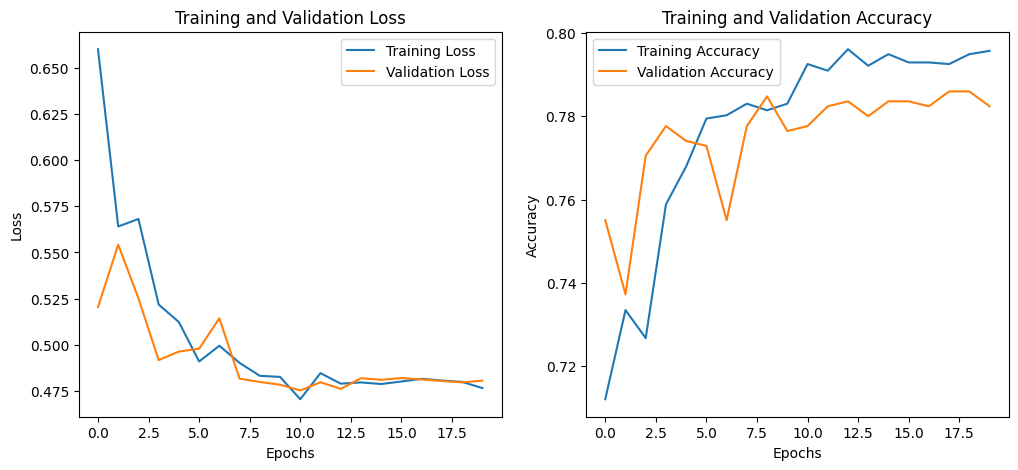

In [ ]:
# Plot training and validation losses
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Test Accuracy: 0.7954815695600476, Precision: 0.799733172663109, Recall: 0.7954105870376654, F1 Score: 0.7947266844525175


<ipython-input-32-a7c6e7844f43>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + list(image_datasets.classes))
<ipython-input-32-a7c6e7844f43>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + list(image_datasets.classes))


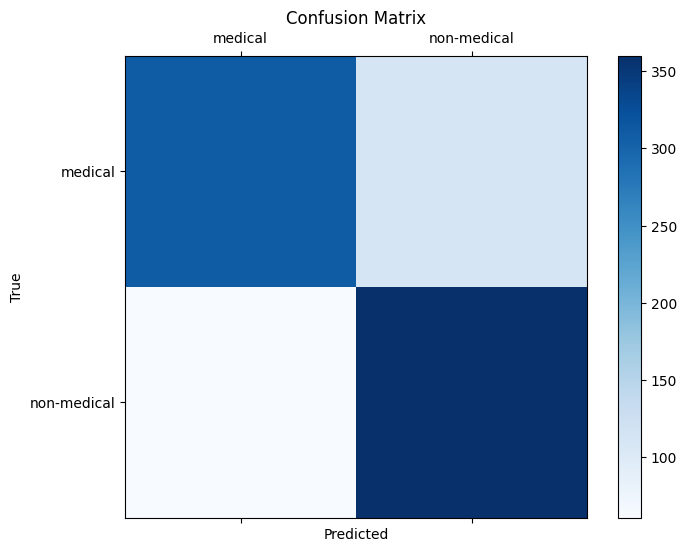

In [ ]:
# Load the best model
model.load_state_dict(torch.load("best_model.pth"))

# Test the model
model.eval()
true_labels, pred_labels = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(predicted.cpu().numpy())

# Test metrics
test_accuracy = accuracy_score(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels, average='macro')
recall = recall_score(true_labels, pred_labels, average='macro')
f1 = f1_score(true_labels, pred_labels, average='macro')
print(f"Test Accuracy: {test_accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")

# Confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + list(image_datasets.classes))
ax.set_yticklabels([''] + list(image_datasets.classes))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()